In [1]:
# make the screen bigger!

from IPython.display import display, HTML

display(HTML(data="""
<style>
    div#notebook-container    { width: 95%; }
    div#menubar-container     { width: 85%; }
    div#maintoolbar-container { width: 99%; }
</style>
"""))

In [2]:
# import all our libraries (if this cell throws an error you may need to reinstall a library)
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
#import shutil   # use to move PDF out of the directory
#import re
from datetime import date, datetime, timedelta
#from itertools import chain
#import statistics as st
import scipy
from scipy import stats
import math
import matplotlib.ticker as ticker
from matplotlib.ticker import FormatStrFormatter
import matplotlib.patches as mpatches
%matplotlib notebook
import itertools

#change this home directory to whatever the project home directroy is on any other computer 
homedir = (r"E:\AmericanSamoa\Projects\ASPA_GUDI\Data_analysis\Precip_collection_part\Python")
os.chdir(homedir)

# paths for files to come from or go to do not change as long as relative paths are kept consistent
path_raw_data = ("Raw_data/Ecoli")

# set fonts
canfont = {'fontname':'Candara'}    # for font setting


In [3]:
os.chdir(homedir)
os.chdir(path_raw_data)

rainfall = pd.read_csv('Airport_rain.csv')
ecoli = pd.read_csv('Monthly_ecoli_data2.csv')
ASCC_file = pd.read_csv('ASCC_rain.csv')

# housekeeping and loading datasets 

# airport rainfall
rainfall['Precipitation']  = rainfall['Precipitation'].replace(' T', '.001')           # any trace rain is small
rainfall['Precipitation'] = pd.to_numeric(rainfall['Precipitation'], errors="coerce")  # any other non numbers are now NAN
rainfall['Precipitation'] = rainfall['Precipitation'].fillna(0.0)   # any NA values need to be numeric 
rainfall = rainfall.dropna(subset = ['Precipitation'], axis=0, how='any') # remove entries without precip values, meaning there was a missing point or something
rainfall['Precipitation'] = rainfall['Precipitation'].apply(lambda y: float(y))    # make sure all rain values are of float type 
rainfall['Date'] = pd.to_datetime(rainfall['Date'], errors='coerce')   # make the dates ddates


#ASCC rainfall 
ASCC_file['DateTime'] = ASCC_file['Date']+' '+ASCC_file['Time']
ASCC_file.columns = ASCC_file.columns.str.strip()     # remove whitespace 

ASCC_file['DateTime'] = pd.to_datetime(ASCC_file['DateTime'], errors='coerce')   # make the dates ddates
ASCC_file['Rain (in)'] = pd.to_numeric(ASCC_file['Rain (in)'], errors="coerce")  # all rain are #s and any other non numbers are now NAN

ASCC_HRrain_data_tmp  = ASCC_file.set_index('DateTime').resample('H')['Rain (in)'].sum()     # sum the rainfall by hours
hr_rain_frame = pd.DataFrame(ASCC_HRrain_data_tmp)
ASCC_HRrain_data = hr_rain_frame.reset_index(drop=False)  
ASCC_HRrain_data['Date'] =ASCC_HRrain_data['DateTime'] 
ASCC_HRrain_data['3hr_rollSum_in'] = ASCC_HRrain_data['Rain (in)'].rolling(3, center=True).sum()   # this is the 3 hr rolling sum
ASCC_HRrain_data['6hr_rollSum_in'] = ASCC_HRrain_data['Rain (in)'].rolling(6, center=True).sum()   
ASCC_HRrain_data['12hr_rollSum_in'] = ASCC_HRrain_data['Rain (in)'].rolling(12, center=True).sum()   
ASCC_HRrain_data['24hr_rollSum_in'] = ASCC_HRrain_data['Rain (in)'].rolling(24, center=True).sum()   
ASCC_HRrain_data['18hr_rollSum_in'] = ASCC_HRrain_data['Rain (in)'].rolling(18, center=True).sum()   

# Randy Ecoli data
ecoli['TC MPN/100ml'] = ecoli['TC MPN/100ml'].apply(lambda y: float(y))    # make sure all  values are of float type 
ecoli['E coli MPN/100 ml'] = ecoli['E coli MPN/100 ml'].apply(lambda y: float(y))    # make sure all values are of float type 
ecoli['Date'] = ecoli['Date']+" "+"13:00"
ecoli['Date'] = pd.to_datetime(ecoli['Date'], errors='coerce')   # make the dates ddates


# Individual Correlations for each well, using hours before sample

for well Taf-33-GUDI, the best of fset is 18 hrs.
for well Mmi-89-GUDI, the best of fset is 63 hrs.
for well Taf-81-GUDI, the best of fset is 18 hrs.
for well Taf-60-GUDI, the best of fset is 138 hrs.


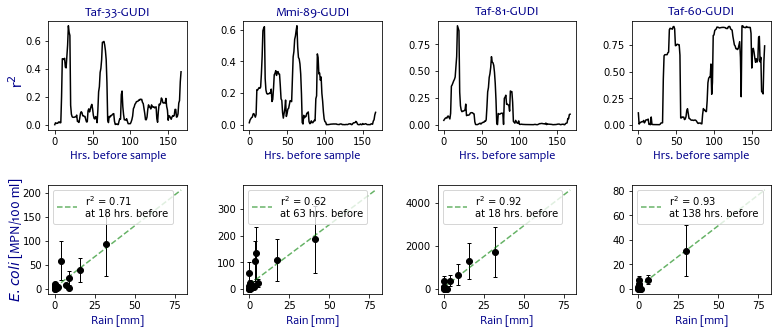

In [5]:
samp_wells = ['Taf-33-GUDI', 'Mmi-89-GUDI', 'Taf-81-GUDI', 'Taf-60-GUDI']

param = 'E coli MPN/100 ml'   # ['TC MPN/100ml'   or   'E coli MPN/100 ml' ] 

fig = plt.figure(figsize=(11, 5))
#fig.text(0.5, 0.023, '48 hr. rainfall total [in], starting 72 hrs. before sampling', ha='center', size=14,  **canfont, color='darkblue' )
fig.text(0.008, 0.74, 'r$^2$' , va='center', rotation='vertical', size=16,  **canfont, color='darkblue' )
fig.text(0.006, 0.30, '$E. coli$ [MPN/100 ml]' , va='center', rotation='vertical', size=14,  **canfont, color='darkblue' )

for idx, p in enumerate(samp_wells): 
    subset_well = ecoli[ecoli['Well'] == p]
    data = ASCC_HRrain_data.merge(subset_well, how='outer', on='Date')   # merge the rain data and the ecoli sample data based on date
    w_samples = pd.notnull(data[param])      # this is a dataframe of just the rain and ecoli data 
    data_w_samples = data[w_samples]
    
    sample_dates = list(data_w_samples.Date.unique()) # this is a list of the dates whre samples happened
    sample_dates = list(pd.to_datetime(sample_dates, errors='coerce')) # put the format back into the format of the dataframe

    Samp_date_bool = ASCC_HRrain_data['Date'].isin(sample_dates)    # boolean to sopolert out which dates are in the sample list
    Sdates_indexes  = list(ASCC_HRrain_data[Samp_date_bool].index)  # The indexes of the rainfall datafile for the dates when samples were taken
    
    r_list = []
    hrs_bak = []
    rang = range(0,168)
    for j in rang: 
        x = ASCC_HRrain_data.iloc[[x - j for x in Sdates_indexes]]['12hr_rollSum_in']
        y = data_w_samples[param]
        slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x, y)   # calculate stats for the ecoli and rainfall data
        r2 = r_value**2
        r_list.append(r2)
        hrs_bak.append(j)
    
    Rs_and_offsets = pd. DataFrame({'r2s':r_list, 'hrs_baks':hrs_bak })
    best_offset = int(Rs_and_offsets.iloc[Rs_and_offsets['r2s'].idxmax()]['hrs_baks'])
    
    ax1 = fig.add_subplot(2,4,idx+1)
    ax1.plot(Rs_and_offsets['hrs_baks'], Rs_and_offsets['r2s'], 'k')
    plt.tight_layout()
    ax1.set_title(p, color='darkblue', **canfont, fontsize=13) 
    plt.xlabel('Hrs. before sample', **canfont, fontsize=12, color='darkblue')

# add the dot plots below
    ax2 = fig.add_subplot(2,4,idx+5) 
    xval = ASCC_HRrain_data.iloc[[x - best_offset for x in Sdates_indexes]]['12hr_rollSum_in']*25.4             
    yval = data_w_samples[param]   
    ax2.yaxis.set_major_formatter(FormatStrFormatter("%.0f"))   # get rid of stupid non-integer axis ticks
    plt.errorbar(xval, yval, label='', marker='o', color='k', yerr=data_w_samples['Ecoli Lower_95'], linestyle='', elinewidth=1, capsize=2)  # plot of the ecoli data 
    plt.xlabel('Rain [mm]', **canfont, fontsize=12, color='darkblue')
    

    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(xval, yval)   # calculate stats for the ecoli and rainfall data
    r2 = r_value**2
    
# this bolock plots the linear regression line using the rainfall offset that produces the highest r2     
    pX = range(0,80)
    pY = slope*pX + intercept
    plt.plot(pX,pY, color='g', linestyle='--', alpha = .6, label = "r$^2$ = "+"$%.2f$"%r2+ " \nat "+str(best_offset)+" hrs. before" )
    
    plt.legend(loc='upper left')
    plt.tight_layout(pad=2)          # the pad feature pulls the plots off of the big axis lables 

    
    print('for well {}, the best of fset is {} hrs.'.format(p, best_offset))
#plt.savefig(os.path.join(r'E:\AmericanSamoa\Projects\ASPA_GUDI\Writing\Figures', 'bacteria vs rainfall.png'), dpi=300)

## Same as above but for unused wells (less than 10 samples )

for well Ili-84-Non-GUDI, the best of fset is 0 hrs.
for well Taf-61-GUDI, the best of fset is 56 hrs.
for well Mmi-67-GUDI, the best of fset is 35 hrs.
for well Taf-72-GUDI, the best of fset is 51 hrs.


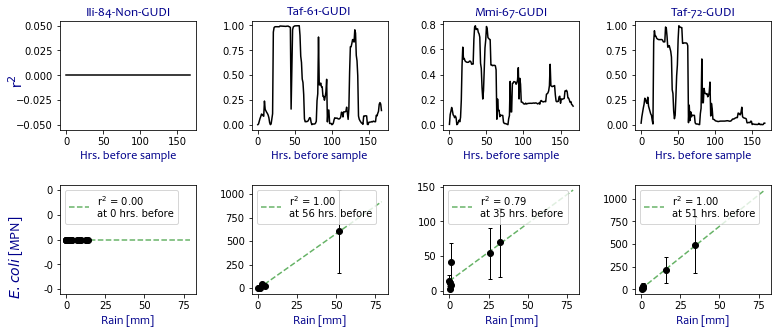

In [7]:
samp_wells = ['Ili-84-Non-GUDI', 'Taf-61-GUDI', 'Mmi-67-GUDI', 'Taf-72-GUDI']


param = 'E coli MPN/100 ml'   # ['TC MPN/100ml'   or   'E coli MPN/100 ml' ] 

fig = plt.figure(figsize=(11, 5))
#fig.text(0.5, 0.023, '48 hr. rainfall total [in], starting 72 hrs. before sampling', ha='center', size=14,  **canfont, color='darkblue' )
fig.text(0.008, 0.74, 'r$^2$' , va='center', rotation='vertical', size=16,  **canfont, color='darkblue' )
fig.text(0.006, 0.25, '$E. coli$ [MPN]' , va='center', rotation='vertical', size=14,  **canfont, color='darkblue' )

for idx, p in enumerate(samp_wells): 
    subset_well = ecoli[ecoli['Well'] == p]
    data = ASCC_HRrain_data.merge(subset_well, how='outer', on='Date')   # merge the rain data and the ecoli sample data based on date
    w_samples = pd.notnull(data[param])      # this is a dataframe of just the rain and ecoli data 
    data_w_samples = data[w_samples]
    
    sample_dates = list(data_w_samples.Date.unique()) # this is a list of the dates whre samples happened
    sample_dates = list(pd.to_datetime(sample_dates, errors='coerce')) # put the format back into the format of the dataframe

    Samp_date_bool = ASCC_HRrain_data['Date'].isin(sample_dates)    # boolean to sopolert out which dates are in the sample list
    Sdates_indexes  = list(ASCC_HRrain_data[Samp_date_bool].index)  # The indexes of the rainfall datafile for the dates when samples were taken
    
    r_list = []
    hrs_bak = []
    rang = range(0,168)
    for j in rang: 
        x = ASCC_HRrain_data.iloc[[x - j for x in Sdates_indexes]]['12hr_rollSum_in']
        y = data_w_samples[param]
        slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x, y)   # calculate stats for the ecoli and rainfall data
        r2 = r_value**2
        r_list.append(r2)
        hrs_bak.append(j)
    
    Rs_and_offsets = pd. DataFrame({'r2s':r_list, 'hrs_baks':hrs_bak })
    best_offset = int(Rs_and_offsets.iloc[Rs_and_offsets['r2s'].idxmax()]['hrs_baks'])
    
    ax1 = fig.add_subplot(2,4,idx+1)
    ax1.plot(Rs_and_offsets['hrs_baks'], Rs_and_offsets['r2s'], 'k')
    plt.tight_layout()
    ax1.set_title(p, color='darkblue', **canfont, fontsize=13) 
    plt.xlabel('Hrs. before sample', **canfont, fontsize=12, color='darkblue')

# add the dot plots below
    ax2 = fig.add_subplot(2,4,idx+5) 
    xval = ASCC_HRrain_data.iloc[[x - best_offset for x in Sdates_indexes]]['12hr_rollSum_in']*25.4             
    yval = data_w_samples[param]   
    ax2.yaxis.set_major_formatter(FormatStrFormatter("%.0f"))   # get rid of stupid non-integer axis ticks
    plt.errorbar(xval, yval, label='', marker='o', color='k', yerr=data_w_samples['Ecoli Lower_95'], linestyle='', elinewidth=1, capsize=2)  # plot of the ecoli data 
    plt.xlabel('Rain [mm]', **canfont, fontsize=12, color='darkblue')
    

    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(xval, yval)   # calculate stats for the ecoli and rainfall data
    r2 = r_value**2
    
# this bolock plots the linear regression line using the rainfall offset that produces the highest r2     
    pX = range(0,80)
    pY = slope*pX + intercept
    plt.plot(pX,pY, color='g', linestyle='--', alpha = .6, label = "r$^2$ = "+"$%.2f$"%r2+ " \nat "+str(best_offset)+" hrs. before" )
    
    plt.legend(loc='upper left')
    plt.tight_layout(pad=2)          # the pad feature pulls the plots off of the big axis lables 

    
    print('for well {}, the best of fset is {} hrs.'.format(p, best_offset))
#plt.savefig(os.path.join(r'E:\AmericanSamoa\Projects\ASPA_GUDI\Writing\Figures', 'bacteria vs rainfall.png'), dpi=300)

Ecoli plots show highest correlation when using rainfall from 48 hr period starting 72 hours prior to sample taken 

(which corresponds well to the peak travel time shown in the turbidity files)  (thus Count_back_days = 3 , and   x = list(range(i-Count_back_days, i)) 

C:\Users\cshuler\Anaconda3\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


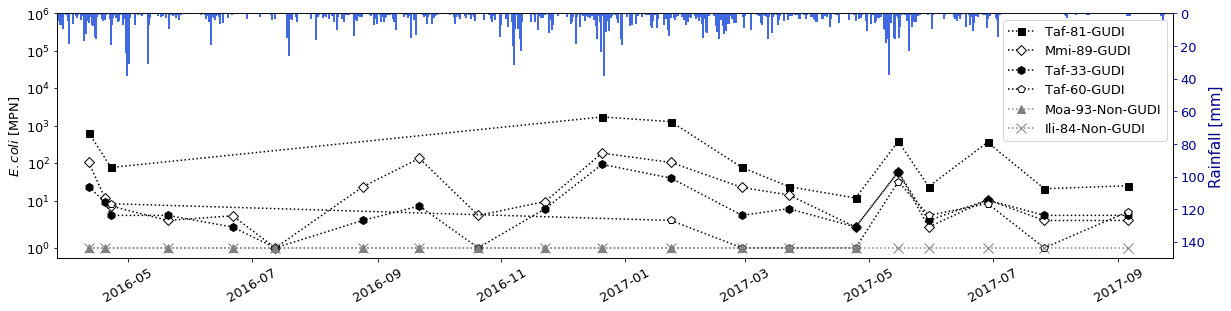

In [11]:
plt.rcParams.update({'font.size': 13})
custom_sites_list = ['Taf-81-GUDI','Mmi-89-GUDI', 'Taf-33-GUDI',  'Taf-60-GUDI', 'Moa-93-Non-GUDI', 'Ili-84-Non-GUDI',]


fig= plt.figure(figsize=(20,5))
ax1 = fig.add_subplot(1, 1, 1)
ax1.set_yscale('symlog')
ax1.set_ylim(.5,1e6)
fig.autofmt_xdate(ha='center')

ax1.set_xlim(736050,736600)
ax1.set_ylabel('$E. coli$ [MPN]')

box = ax1.get_position()
ax1.set_position([box.x0, box.y0, box.width, box.height])
ax1.set_position([box.x0, box.y0, box.width * 0.8, box.height])

mkrs = itertools.cycle(["s", "D", "h", 'p','^', 'x'])
mkrs_type = itertools.cycle(["k",  'white', 'k', "white", 'grey', 'white'])
colors = itertools.cycle(["k", "k", "k", 'k', 'grey','grey'])
sizes = itertools.cycle([7,7,8,8,8,10])

mk = itertools.cycle(mkrs)
fc = itertools.cycle(mkrs_type)
co = itertools.cycle(colors)
si = itertools.cycle(sizes)

for i in custom_sites_list:  
    individual_frame = ecoli[ecoli['Well'] == i]              # just values for easy plug and play
    individual_frame = individual_frame.sort_values(by=['Date'], axis=0)
    xval = individual_frame['Date']
    yval = individual_frame['E coli MPN/100 ml']+1
    plt.plot(xval, yval, label=i,marker=next(mk), linestyle=':', color=next(co), markerfacecolor= next(fc), markersize=next(si))  # plot of the ecoli data
ax1.legend(loc='upper right') #, bbox_to_anchor=(.7, .5))
    
ax2 = ax1.twinx() 
ax2.bar(ASCC_HRrain_data['DateTime'], ASCC_HRrain_data['Rain (in)']*25.4 , width=1, color='royalblue', alpha=1)           #   Make bar plot
ax2.set_ylim(150,0)   
ax2.set_ylabel('Rainfall [mm]', fontsize=15, color='darkblue') 
ax2.tick_params('y', colors='darkblue')